# Processing and filtering marker gene datasets

Here, we'll walk through some filtering strategies applicable to compositional marker gene studies. We will employ several custom R functions designed to manipulate phyloseq-class datasets that aid in the processing, filtering, and reproducability of marker gene studies. We apply this workflow to a subset of a larger 16S community dataset, though these scripts are scalable to any marker gene and large datasets with thousands of taxa and samples. <br>
<br>
Briefly, the aims of this vignette and associated functions are to:<br>
1. Estimate dataset-specific filtering parameters<br>
2. Provide a set of robust and highly reproducible processing, filtering, and exporting functions for marker gene studies<br>
3. Faciltate transparency and reproducability of marker gene data analysis<br>

<div class="alert alert-block alert-info">
<b>A preface on filtering:</b> Filtering is an <i>essential</i> step in the analyis of marker gene datasets. This workflow uses a two-pronged approach to filtering contaminants from read datasets. That is, we attempt to remove two types of contamination: <br>
<br>
1. Real biological sequences that have cross contaminated unassociated samples. <br>
<br>
2. Exogenous contaminants introduced during sample preparation. <br>
<br>
To achieve this, we first filter out taxa below an abundance threshold individually within each sample (WS). We estimate this threshold empirically by measuring the number of amplicon sequence variants (ASVs) within known mock communities under various thresholds and select the threshold that returns the desired results. Next, we remove control samples from the dataset and then apply several across-sample (AS) filters (prevalence, CV) to remove exogenous contaminants present as low abundance ASVs. 
</div>

***

## Before we begin...
This workflow assumes that your sequencing project has been/includes:
-  processed with __[dada2](https://benjjneb.github.io/dada2/index.html)__ (namely, that your ASV names are the ASV nucleotide sequences)
-  converted into a __[phyloseq](https://joey711.github.io/phyloseq/)__ object
-  a mock community or other positive control of known composition

In [1]:
library(RCurl); packageVersion("RCurl")

Loading required package: bitops


[1] ‘1.95.4.10’

In [2]:
library(phyloseq); packageVersion("phyloseq")

[1] ‘1.19.1’

In [3]:
library(cowplot); packageVersion("cowplot")

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



[1] ‘0.9.2’

In [4]:
library(ggplot2); packageVersion("ggplot2")
theme_set(theme_bw()) #gray is a bummer

[1] ‘2.2.1’

In [5]:
library(tidyr); packageVersion("tidyr")


Attaching package: ‘tidyr’

The following object is masked from ‘package:RCurl’:

    complete



[1] ‘0.8.1’

## Getting started
First, we'll need to source the functions into our R environment. We can do that directly from Github with some handy functions provided by HW. 

In [6]:
load("/Users/bpb/Desktop/marker_gene_filtering_functions/marker_gene_processing_vignette/nigerian.dada2.RData")
NI <- n.phy.dada2

library(devtools); packageVersion("devtools")
myfunctions <- "https://github.com/itsmisterbrown/marker_gene_processing_scrips/raw/master/marker_gene_processing_functions.R"
source_url(myfunctions) #compliments of Hadley

[1] ‘1.13.6’

SHA-1 hash of file is 65383a3ebe077f5cab1bd7a260642910083ff275


In [7]:
NI %>%
  subset_taxa(Phylum != "NA" & 
                Phylum != "Cyanobacteria/Chloroplast") -> NI

table(tax_table(NI)[, "Phylum"], exclude = NULL)


              Acidobacteria              Actinobacteria 
                         22                         629 
            Armatimonadetes               Bacteroidetes 
                          6                         359 
   candidate_division_WPS-1 Candidatus_Saccharibacteria 
                          1                           6 
                Chloroflexi             Deferribacteres 
                         17                           1 
        Deinococcus-Thermus                  Firmicutes 
                         10                        1211 
               Fusobacteria            Gemmatimonadetes 
                         25                           1 
                Nitrospirae              Planctomycetes 
                          3                          59 
             Proteobacteria                Spirochaetes 
                        815                           3 
              Synergistetes                 Tenericutes 
                          1   

For this vignette, we'll work with a subset of a recent study of stool samples from Nigerian infants. Let's take a look at the raw dataset

In [8]:
NI

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3176 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 3176 taxa by 7 taxonomic ranks ]

Our unfiltered object has 3,176 taxa (that's a lot!), though some of those bugs are likely contaminants or irrelevent stochastic associates. We'll use some filtering functions to pare that number down to a smaller set of  bugs that we can interrogate with downstream analyses. <br>
<br>
## Filtering
<br>
First, we'll estimate the threshold at which our data suggest cross contamination persists. We can do this with the __estimate.threshold()__ function.

In [9]:
(ws.threshold <- estimate.WSthreshold(ps = NI, WSmin = 2e-4, WSmax = 4e-4, WSstep = 1e-5, controlID = "pc1"))

control.taxa.count,read.count,read.percent,threshold.value
22,92629339,99.60555,0.00020
22,92616259,99.59148,0.00021
22,92600206,99.57422,0.00022
22,92588605,99.56175,0.00023
22,92573774,99.54580,0.00024
22,92562863,99.53407,0.00025
22,92554267,99.52482,0.00026
22,92540847,99.51039,0.00027
22,92528882,99.49753,0.00028
22,92519809,99.48777,0.00029


And let's take a peek at a quick visual summary

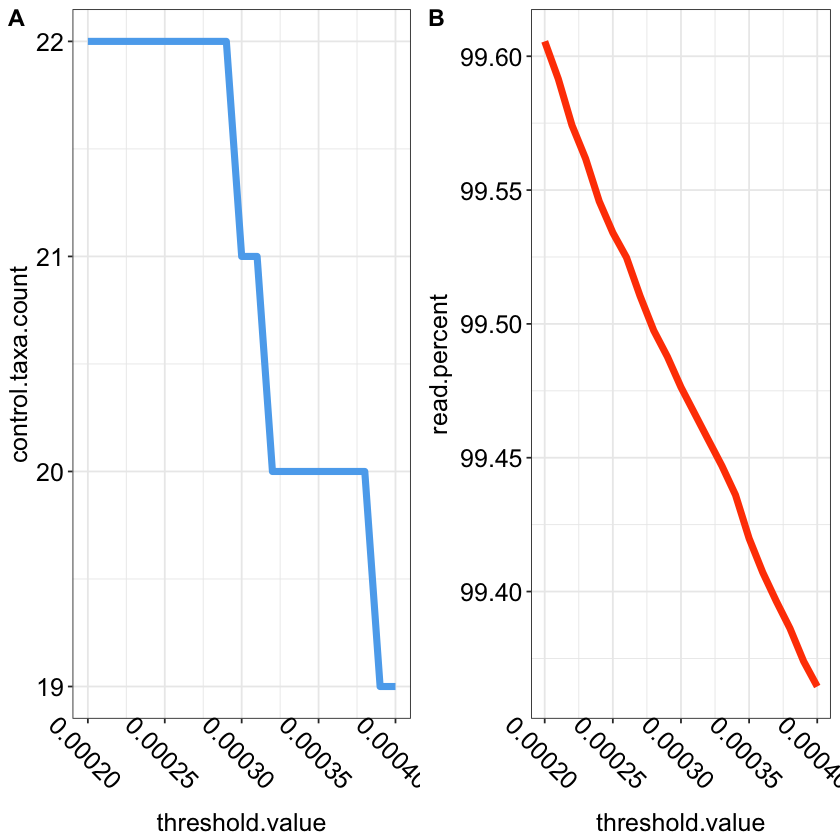

In [10]:
plot1 <- ggplot(data = ws.threshold, aes(x = threshold.value, y = control.taxa.count)) + geom_line(size=2, color="steelblue2") + 
  theme(axis.text.y = element_text(size = 15, colour = "black"),
        axis.text.x = element_text(size = 15, colour = "black", angle = 315, vjust = 0.7),
        axis.title.x = element_text(size = 15, colour = "black"),
        axis.title.y = element_text(size = 15, colour = "black"))

plot2 <- ggplot(data = ws.threshold, aes(x = threshold.value, y = read.percent)) + geom_line(size=2, color="orangered1") + 
  theme(axis.text.y = element_text(size = 15, colour = "black"),
        axis.text.x = element_text(size = 15, colour = "black", angle = 315, vjust = 0.7),
        axis.title.x = element_text(size = 15, colour = "black"),
        axis.title.y = element_text(size = 15, colour = "black")) 

plot_grid(plot1, plot2, labels = "AUTO")



***
It looks like a WS threshold of 3.2e-4 is sufficient for recovering the desired taxa count for our mock communities without sacrificing too many reads. Now that we've determined our threshold, let's apply this cutoff to our dataset with the __filter.dataset()__ function. __filter.dataset()__ is a multifaceted filtering funtion that applies a WS filter (eg. sets the abundance of filtered taxa to 0 in that sample), and several AS filters.

In [11]:
(as.threshold <- estimate.ASthreshold(ps = NI, WSF = 3.2e-4, minLIB = 4000, controlID = "pc1", controlCAT = "timepoint", 
                                      controlFACTOR = "control", Pmin = 0.01, Pmax = 0.1, Pstep = 0.005, CVmin = 0, CVmax = 5, CVstep = 0.1, 
                                      RAFmin = 1e-7, RAFmax = 1e-5, RAFstep = 1e-7))

relative.abundance.filter,ASV.count
1.0e-07,678
2.0e-07,631
3.0e-07,616
4.0e-07,605
5.0e-07,597
6.0e-07,592
7.0e-07,589
8.0e-07,585
9.0e-07,584
1.0e-06,582


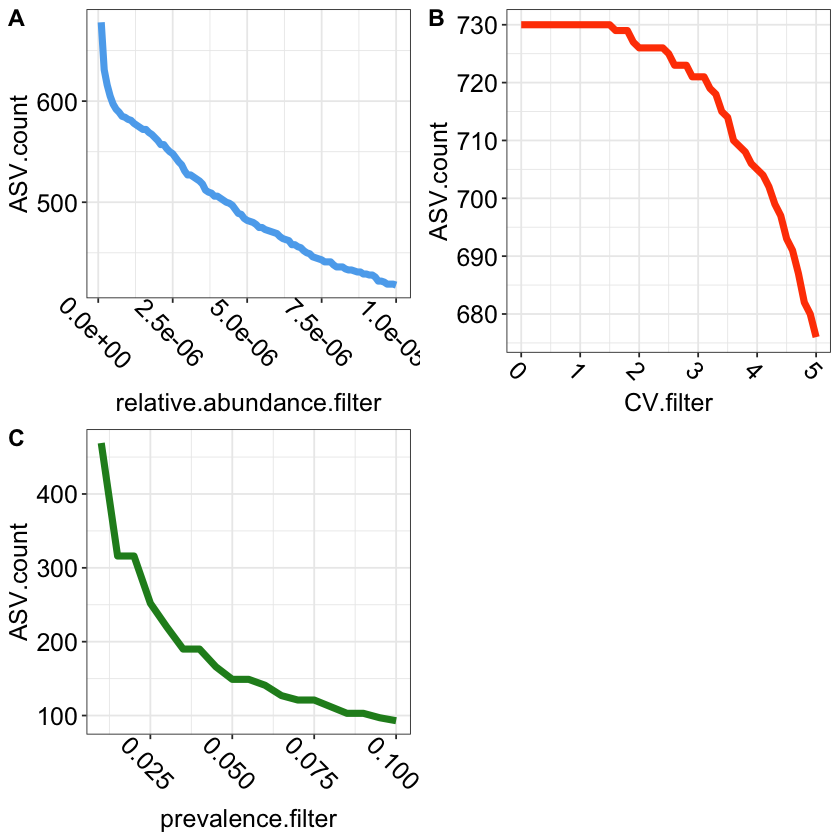

In [12]:
RA.stats <- as.threshold$relative.abundance.filtering.stats
CV.stats <- as.threshold$CV.filtering.stats
P.stats <- as.threshold$prevalence.filtering.stats
ASV.stats <- as.threshold$ASV.filtering.stats
ASV.stats.c <- ASV.stats[complete.cases(ASV.stats),]

plot3 <- ggplot(data = RA.stats, aes(x = relative.abundance.filter, y = ASV.count)) + geom_line(size=2, color="steelblue2") + 
  theme(axis.text.y = element_text(size = 15, colour = "black"),
        axis.text.x = element_text(size = 15, colour = "black", angle = 315, vjust = 0.7),
        axis.title.x = element_text(size = 15, colour = "black"),
        axis.title.y = element_text(size = 15, colour = "black"))

plot4 <- ggplot(data = CV.stats, aes(x = CV.filter, y = ASV.count)) + geom_line(size=2, color="orangered1") + 
  theme(axis.text.y = element_text(size = 15, colour = "black"),
        axis.text.x = element_text(size = 15, colour = "black", angle = 315, vjust = 0.7),
        axis.title.x = element_text(size = 15, colour = "black"),
        axis.title.y = element_text(size = 15, colour = "black")) 

plot5 <- ggplot(data = P.stats, aes(x = prevalence.filter, y = ASV.count)) + geom_line(size=2, color="forestgreen") + 
  theme(axis.text.y = element_text(size = 15, colour = "black"),
        axis.text.x = element_text(size = 15, colour = "black", angle = 315, vjust = 0.7),
        axis.title.x = element_text(size = 15, colour = "black"),
        axis.title.y = element_text(size = 15, colour = "black")) 


plot_grid(plot3, plot4, plot5, labels = "AUTO")


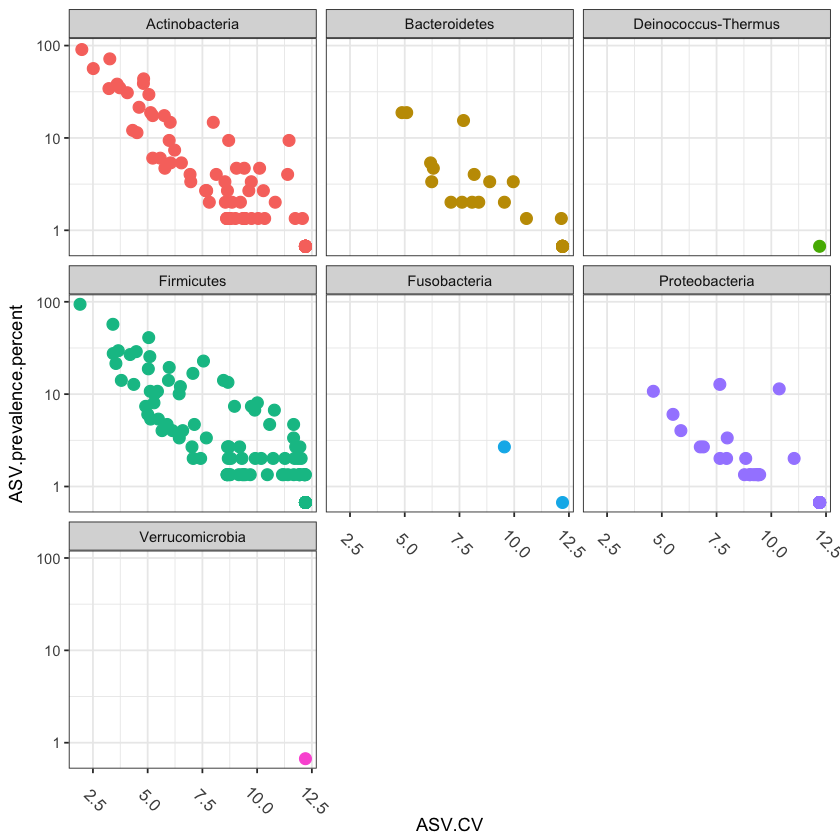

In [13]:
ggplot(data = ASV.stats.c, aes(x = ASV.CV, y = ASV.prevalence.percent, color=Phylum)) + geom_point(size=3) + 
  facet_wrap("Phylum", scales = "fixed") + scale_y_log10() +
  theme(axis.text.x = element_text(size = 10, angle = 315, vjust = 0.2), legend.position = "none")


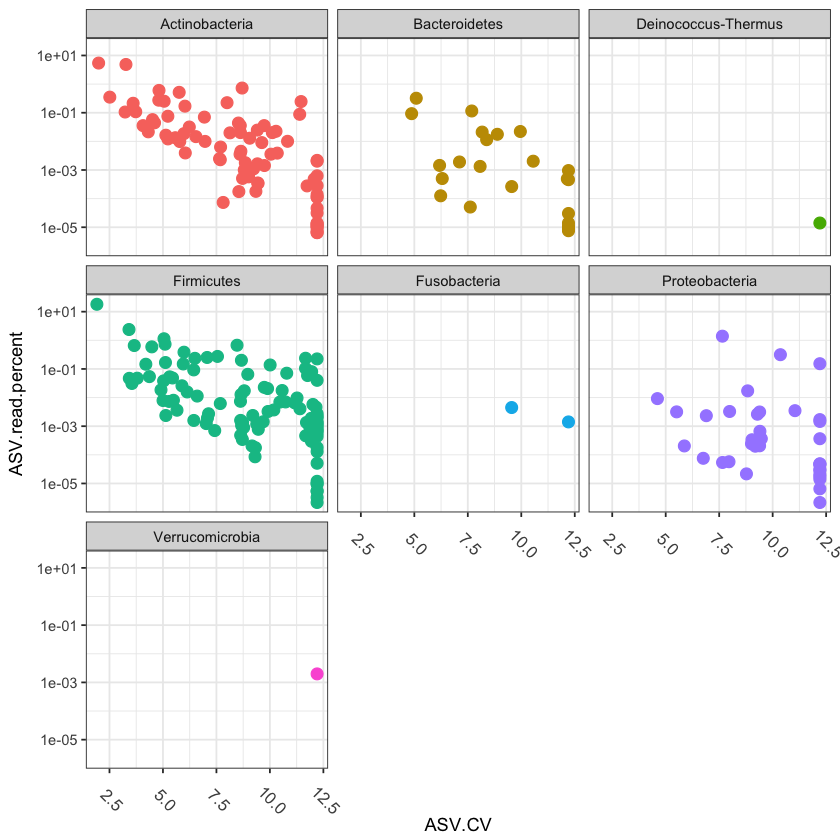

In [14]:
ggplot(data = ASV.stats.c, aes(x = ASV.CV, y = ASV.read.percent, color=Phylum)) + geom_point(size=3) + 
  facet_wrap("Phylum", scales = "fixed") + scale_y_log10() +
  theme(axis.text.x = element_text(size = 10, angle = 315, vjust = 0.2), legend.position = "none")


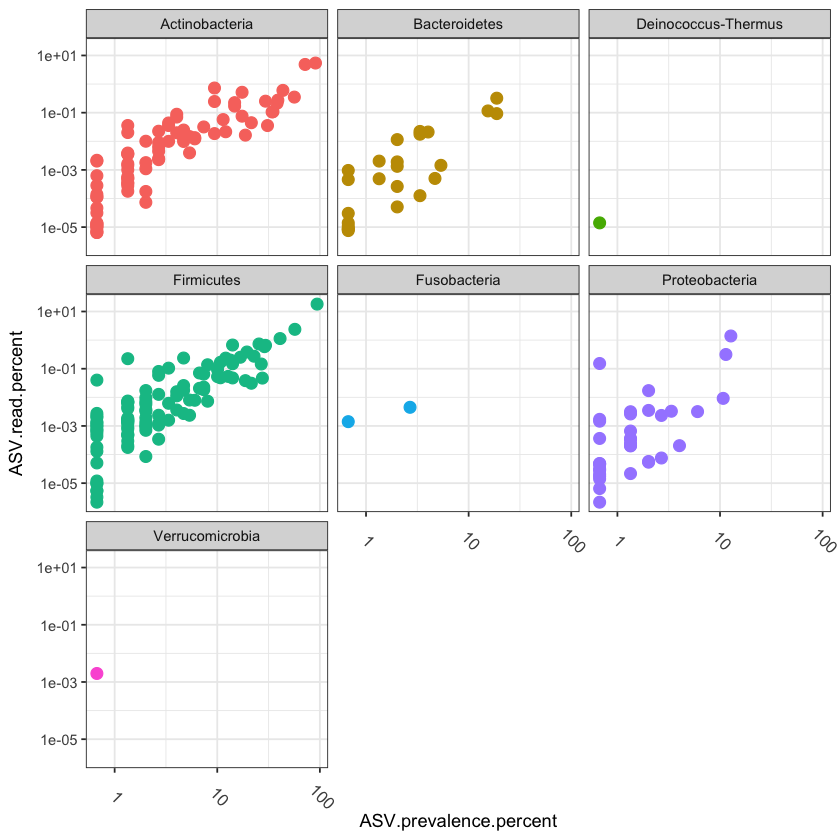

In [15]:
ggplot(data = ASV.stats.c, aes(x = ASV.prevalence.percent, y = ASV.read.percent, color=Phylum)) + geom_point(size=3) + 
  facet_wrap("Phylum", scales = "fixed") + scale_y_log10() + scale_x_log10() +
  theme(axis.text.x = element_text(size = 10, angle = 315, vjust = 0.2), legend.position = "none")


<div class="alert alert-block alert-info">
The <b>filter.dataset()</b> function does what its name suggests and provides a few other handy features. It can apply both within-sample (WS) and across-sample (AS) filters to the dataset, and remove samples based on sequencing depth or via match to a provided metadata identifier (eg. 'control' samples). <br>
<br>
<b>Input:</b> <br>
<b>controlCAT:</b> The sample data category to use to flag samples for removal by controlFACTOR<br>
<b>controlFACTOR:</b> The factor within controlCAT linked to samples that should be removed<br>
<b>minLIB:</b> The minimum sequence depth for a sample to be retained<br>
<b>PF:</b> Prevalence filter; the percentage of reads across the dataset of an ASV for that ASV to be retained <br>
<b>CVF:</b> Coefficient of Variation; the highest CV value of an ASV in order to be retained
<br><br>
<b>Output:</b> <br>
<b>control.taxa.sequences</b>
-  These are the nucleotide sequences of the taxa remaining in the positive control after applying the within-sample filter threshold.  <br>
<b>taxonomy.of.control.taxa</b>
-   The taxonomy of taxa in the positive control are output in the same order as the sequences, above. Generally useful for validating that the bugs detected in your mock community are as intended. <br>
<b>read.count.table</b>
-  This table lists the read count and percentage remaining after each filtering step. Control samples are removed after the WS filter and before the AS filter(s) and, as such, will list NA values for AS filter statistics.  <br>
<b>prevalence.filter.threshold</b>
-  The read count corresponding to the percentage given to the P parameter. <br>
<b>filtered.phyloseq</b>
-  the shiny new (phyloseq class) filtered dataset with control samples removed. <br>
<br>

</div>


In [16]:
NI.f <- filter.dataset(ps = NI, controlID = "pc1", controlCAT = "timepoint", 
                      controlFACTOR = "control", WSF = 3.2e-4, PF = 0.02, RAF = 1e-5, CVF = 1, minLIB = 4000, return.all = TRUE)

In [17]:
NI.f$ntaxa.in.control

[1] 20

In [18]:
NI.f$control.taxa.sequences

[1] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTGGTCTTGACATCCACAGAACTTTCCAGAGATGGATTGGTGCCTTCGGGAACTGTGAGACAGG"
 [2] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTGGTCTTGACATCCACGGAAGTTTTCAGAGATGAGAATGTGCCTTCGGGAACCGTGAGACAGG"
 [3] "GGACCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAAATCTTGACATCCTTTGACAACTCTAGAGATAGAGCCTTCCCCTTCGGGGGACAAAGTGACA"
 [4] "GGACCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAAATCTTGACATCCTCTGACCCCTCTAGAGATAGAGTTTTCCCCTTCGGGGGACAGAGTGACA"
 [5] "GGACCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAAATCTTGACATCCTTTGACAACTCTAGAGATAGAGCTTTCCCCTTCGGGGGACAAAGTGACA"
 [6] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCCGATGCTATTCTTAGAGATAGGAAGTTACTTCGGTACATCGGAGACAGG"
 [7] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGCCTTGACATCCAATGAACTTTCTAGAGATAGATTGGTGCCTTCGGGAACATTGAGACAGG"
 [8] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGCAGAACCTTACCAACCCTTGACATGGCGATCGCGGTTCCAGAGATGGTTCCTTCAGTTCGGCTGGATCGCACACA"
 [9] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCTTCTGACCGGCCTAGAGATAGGCTTTCTCTTCGGAGCAGAAGTGACAGG"
[10] "GGGCCCGCACAAGCGGAGGAACATGTGGTTTAATTCGATGATACGCGAGGAACCTTACCCGGGCTTAAATTGCAGATGAATTACGGTGAAAGCCGTAAGCCGCAAGGCATCTGTGAAGGTGC"
[11] "GGACCCGCACAAGCGGTGGATGATGTGGATTAATTCGATGCAACGCGAAAAACCTTACCTACCCTTGACATGTCTGGAATGCCGAAGAGATTTGGTAGTGCTCGCAAGAGAACCGGAACACA"
[12] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCAGTGCAAACCTAAGAGATTAGGTGTTCCCTTCGGGGACGCTGAGACAGG"
[13] "GGCCCCGCACAAGCGGCGGAGCATGCGGATTAATTCGATGCAACGCGTAGAACCTTACCTGGGTTTGACATGGATCGGGAGTGCTCAGAGATGGGTGTGCCTCTTTTGGGGTCGGTTCACAG"
[14] "GGACCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAAATCTTGACATCCTCTGATCCCTCTAGAGATAGAGGTTTCCCCTTCGGGGGACAGAGTGACA"
[15] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCTCTGACAACCCTAGAGATAGGGCTTCTCCTTCGGGAGCAGAGTGACAGG"
[16] "GGGCCCGCACAAGCAGCGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCTAGACTTGACATCTCCTGAATTACCCTTAATCGGGGAAGCCCTTCGGGGCAGGAAGACAGGTG"
[17] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCTGGCCTTGACATGCTGAGAACTTTCCAGAGATGGATTGGTGCCTTCGGGAACTCAGACACAGG"
[18] "GGACCCGCACAAGCGGTGGATGATGTGGATTAATTCGATGCAACGCGAAGAACCTTACCTGGTCTTGACATGTACGGAATCCTCCGGAGACGGAGGAGTGCCTTCGGGAGCCGTAACACAGG"
[19] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCTTTGACCACTCTGGAGACAGAGCTTTCCCTTCGGGGACAAAGTGACAGG"
[20] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTGGCCTTGACATACTAGAAACTTTCCAGAGATGGATTGGTGCCTTCGGGAATCTAGATACAGG"

In [19]:
NI.f$taxonomy.of.control.taxa

Kingdom,Phylum,Class,Order,Family,Genus,Species
Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Salmonella,NA
Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Escherichia/Shigella,NA
Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,NA
Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,NA
Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,NA
Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,mutans
Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,NA
Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Rhodobacter,azotoformans/johrii/megalophilus/sphaeroides
Bacteria,Firmicutes,Bacilli,Lactobacillales,NA,NA,NA
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,vulgatus


In [20]:
NI.f$read.count.table[135:149, ]

,unfiltered.read.count,WSfiltered.read.count,WSfiltered.read.percent,ASfiltered.read.count,ASfiltered.read.percent
N.0395..Week.36,1256538,1249754,99.46010,1085942,86.42333
N.0395..Week.4,523876,521167,99.48289,520575,99.36989
N.0704..baseline,71953,70418,97.86666,68669,95.43591
N.0704..Week.15,782531,779509,99.61382,778706,99.51120
N.0704..Week.36,886216,880152,99.31574,870931,98.27525
N.0704..Week.4,177996,175010,98.32243,172630,96.98533
N.0705..baseline,888231,882986,99.40950,848226,95.49610
N.0705..Week.15,1193231,1184010,99.22722,1181706,99.03414
N.0705..Week.4,951118,944238,99.27664,936236,98.43532
nc1,111821,109272,97.72046,NA,NA


In [21]:
NI.f$relative.abundance.filter.read.count

[1] 913.1401

In [22]:
NI.f$prevalence.filter.sample.count

[1] 2.86

In [23]:
(NIF <- NI.f$filtered.phyloseq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 291 taxa and 143 samples ]
sample_data() Sample Data:       [ 143 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 291 taxa by 7 taxonomic ranks ]

## Processing and exporting
<br>Now that we've filtered the dataset to our liking, we'll export all of the data associated with our final, filtered dataset using the __write.dataset()__ function. Unfortunately, I've never been able to get the biomformat package (v1.2.0) to play nice with my version of phyloseq, but y'all may have more luck with newer versions. In case the kinks have been worked out, I'd recommend using the __write.dataset.biom()__ function to export your dataset directly to biom format. Until then, we'll use __write.dataset()__ to perform some final minor modifications and export our dataset.

<div class="alert alert-block alert-info">
Prior to writing output, both functions rename all taxa as ASV1, ASV2, ..., ASVN, for ease of visualization and handling in downstream analysis.<br>
<br>
<b>Output:</b> The output of these scripts are as follows: <br>
<br>
<b>Both:</b>
-  FASTA of all ASV sequences. dada2 does not assign names to each ASV, but rather uses the nucleotide sequence as the identifier; we can leverage this feature to write an output in FASTA format of each ASV before we assign names.  <br>
<br>
<b>write.dataset.biom():</b>
-   A biom file with observation and sample metadata integrated. I've run into problems attempting to import the resulting biom back into phyloseq, but this might warrant a closer look with a newer version. <br>
<br>
<b>write.dataset():</b>
-  A standard count table (eg. OTU table) of read counts of taxa (ASVs) within each sample. <br>
-  A taxonomy table with the sequence identifier (eg. ASV1) in the first column and semicolon-separated taxonomy in the second column.<br>
-  A sample data table of all associated metadata. 
<br>

</div>
<br>
<div class="alert alert-block alert-success">
<b>TIP:</b> Before writing, all files written by <b>write.dataset()</b> are formatted for easy merging into a biom file using the  <A HREF = "http://biom-format.org/documentation/biom_conversion.html">standalone biom package</A> without any further manipulation. 
</div>

In [24]:
fp <- paste(getwd(), "/", sep = "")
NIF.f <- write.dataset(ps = NIF, filepath = fp, fileprefix = "Nif.f")

[1] "/Users/bpb/Desktop/marker_gene_filtering_functions/Nif.f_ASVs.fasta"
[1] "/Users/bpb/Desktop/marker_gene_filtering_functions/Nif.f_ASV_table.txt"
[1] "/Users/bpb/Desktop/marker_gene_filtering_functions/Nif.f_ASV_taxonomy.txt"
[1] "/Users/bpb/Desktop/marker_gene_filtering_functions/Nif.f_sample_data.txt"


Boom! We've now written all of the metadata associated with our filtered marker gene study to various output files. Now, let's take a final peek at our ASV count table in a format that's a little more friendly on the eyes. 

In [25]:
phyloseq::otu_table(NIF.f)[1:10, 1:10]

,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,ASV10
N.0055..baseline,0,57092,0,0,0,0,532461,8519,0,55386
N.0055..Week.15,3137,50,126,170,12,16,59,26,27,0
N.0055..Week.36,1745,583068,295,7571,0,0,0,0,161094,0
N.0055..Week.4,1552,4311,24642,3267,422,0,0,104530,0,1295
N.0170..baseline,1438,368,362,772,431,392,1023,361,265,1382
N.0170.Week.15,136177,269,99767,0,642,505,1201,0,3606,0
N.0170.Week.36,367401,8053,17969,0,40399,31963,271,0,50041,752
N.0170.Week.4,335868,788,77043,0,11923,6800,1818,42446,4513,0
N.0183..baseline,12981,5611,44012,1452,1553,1915,1577,1821,231,2531
N.0183.Week.15,58948,97,23709,0,111,0,0,56,2227,0
